# EKSPERIMEN TRANSFORMER PADA BERBAGAI JENIS DATA UNTUK MENENTUKAN PARAMETER TERBAIK

Nama  : Maulana Seno Aji Yudhantara  
NRP   : 152022065  
Kelas : IFB-454 DEEP LEARNING  

### Deskripsi Tugas:
Tugas ini bertujuan untuk melakukan eksperimen terhadap arsitektur Transformer dengan berbagai kombinasi parameter pada tiga dataset berbeda. Hasil eksperimen ini akan digunakan untuk menentukan konfigurasi parameter terbaik dari arsitektur Transformer yang sesuai dengan masing-masing jenis dataset.

### Dataset yang Digunakan:
1. **IMDBDataset**  
   Jenis: Teks  
   Tujuan: Klasifikasi sentimen (positif/negatif)

2. **AGNewsClassificationDataset**  
   Jenis: Teks  
   Tujuan: Klasifikasi topik berita

3. **ElectricityLoadForecasting**  
   Jenis: Time Series  
   Tujuan: Regresi prediksi beban listrik

### Struktur Eksperimen:
- Import library
- Load dan eksplorasi dataset
- Preprocessing data
- Menentukan kombinasi parameter untuk eksperimen
- Melatih dan mengevaluasi model
- Membandingkan hasil dan visualisasi performa model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Tahap 1 – Import Semua Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import time
import random
import re
from itertools import product

# TensorFlow dan Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization
from keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D, LayerNormalization, MultiHeadAttention

# Untuk evaluasi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error

# Untuk menonaktifkan warning
import warnings
warnings.filterwarnings('ignore')


# **Tahap 2 - Load Dataset**

## Tahap 2.1 – Load Dataset IMDB (Sentiment Classification)

Dataset IMDB digunakan untuk tugas klasifikasi teks, di mana setiap sampel terdiri dari ulasan film dan label sentimennya (positif atau negatif).  
Dataset ini cocok untuk menguji performa arsitektur Transformer dalam memahami konteks teks dan mengklasifikasikan berdasarkan emosi/kecenderungan opini pengguna.

**Struktur Dataset:**
- `review`: Teks ulasan pengguna terhadap film.
- `sentiment`: Label target berupa `positive` atau `negative`.

Dataset disimpan dalam file `IMDBDataset.csv` di folder `IMDBDataset/`.

In [3]:
# Lokasi file
imdb_path = os.path.join("/content/drive/MyDrive/Tugas-3data-transformer/IMDBDataset/IMDBDataset.csv")

# Membaca data
df_imdb = pd.read_csv(imdb_path)

# Menampilkan 5 data pertama
df_imdb.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Tahap 3 - Preprocessing Dataset**

## Tahap 3.1 – Preprocessing Dataset IMDB

Agar dataset IMDB dapat digunakan dalam model Transformer, dilakukan beberapa tahap preprocessing sebagai berikut:

1. **Pemetaan Label**: Label `positive` diubah menjadi 1 dan `negative` menjadi 0.
2. **Pembersihan Teks**: Menghapus karakter HTML, tanda baca, dan mengonversi ke huruf kecil.
3. **Tokenisasi dan Padding**: Menggunakan tokenizer dari TensorFlow `TextVectorization`.
4. **Split Data**: Dataset dibagi menjadi data latih (80%) dan data uji (20%).

Tahapan ini penting untuk memastikan bahwa teks siap digunakan oleh embedding layer dalam arsitektur Transformer.


In [4]:
# 1. Pemetaan label: 'positive' -> 1, 'negative' -> 0
df_imdb['sentiment'] = df_imdb['sentiment'].map({'positive': 1, 'negative': 0})

# 2. Pembersihan teks
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Hapus tag HTML
    text = re.sub(r'[^\w\s]', '', text)  # Hapus tanda baca
    text = text.lower()  # Ubah ke lowercase
    return text

df_imdb['review'] = df_imdb['review'].apply(clean_text)

# 3. Split data
X_imdb = df_imdb['review'].values
y_imdb = df_imdb['sentiment'].values

X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(
    X_imdb, y_imdb, test_size=0.2, random_state=42)

# 4. Tokenisasi & padding otomatis dengan TextVectorization
max_tokens = 20000  # Vocab size
output_sequence_length = 250  # Panjang maksimal input

vectorizer_imdb = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length)
vectorizer_imdb.adapt(X_train_imdb)

# Transformasi teks ke token
X_train_imdb_vec = vectorizer_imdb(X_train_imdb)
X_test_imdb_vec = vectorizer_imdb(X_test_imdb)


# **Tahap 4 - Menentukan Parameter yang Dieksperimenkan**

### Tahap 4.1 – Menentukan Parameter yang Akan Dieksperimenkan (IMDB Dataset)

Untuk menemukan model terbaik pada dataset IMDB, dilakukan eksperimen terhadap beberapa kombinasi parameter penting dalam arsitektur Transformer. Tujuan eksperimen ini adalah mengevaluasi performa model berdasarkan akurasi klasifikasi sentimen dan efisiensi waktu pelatihan.

Berikut adalah parameter yang akan diuji:
1. **Jumlah Layer Transformer (num_layers)**  
   Mengatur jumlah encoder layer pada arsitektur Transformer.  
   - Variasi: 2, 4

2. **Jumlah Head Attention (num_heads)**  
   Mengontrol berapa banyak kepala perhatian pada self-attention mechanism.  
   - Variasi: 2, 4

3. **Ukuran Dimensi Feed-Forward Layer (ff_dim)**  
   Ukuran dari layer dense yang mengikuti attention mechanism.  
   - Variasi: 128, 256

4. **Ukuran Embedding (embedding_dim)**  
   Dimensi vektor representasi untuk setiap token.  
   - Variasi: 64, 128

Eksperimen akan dilakukan dengan mencoba kombinasi dari parameter-parameter tersebut untuk menemukan konfigurasi terbaik pada dataset ini.


# **Tahap 5 - Membangun dan Melatih Model Transformer (Dataset IMDB)**

### Definisi Layer Transformer Sederhana


In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


### Fungsi Build Model Transformer

In [6]:
def build_transformer_model(embed_dim, num_heads, ff_dim, num_layers, vocab_size=20000, maxlen=250):
    inputs = keras.Input(shape=(maxlen,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


### Training Model dengan Kombinasi Parameter

In [7]:
param_combinations = list(product([2, 4], [2, 4], [128, 256], [64, 128]))  # num_layers, num_heads, ff_dim, embedding_dim
imdb_results = []

for num_layers, num_heads, ff_dim, embed_dim in param_combinations:
    print(f"Training: layers={num_layers}, heads={num_heads}, ff_dim={ff_dim}, embed_dim={embed_dim}")

    model = build_transformer_model(embed_dim, num_heads, ff_dim, num_layers)

    start = time.time()
    history = model.fit(X_train_imdb_vec, y_train_imdb,
                        epochs=5, batch_size=32,
                        validation_split=0.2, verbose=1)
    end = time.time()

    _, acc = model.evaluate(X_test_imdb_vec, y_test_imdb, verbose=0)
    imdb_results.append({
        "layers": num_layers,
        "heads": num_heads,
        "ff_dim": ff_dim,
        "embed_dim": embed_dim,
        "accuracy": acc,
        "time": round(end - start, 2)
    })

    print(f"✓ Acc: {acc:.4f} | Waktu: {round(end - start, 2)} detik\n")


Training: layers=2, heads=2, ff_dim=128, embed_dim=64
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.7679 - loss: 0.4543 - val_accuracy: 0.8755 - val_loss: 0.3000
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.9296 - loss: 0.1871 - val_accuracy: 0.8627 - val_loss: 0.3905
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9575 - loss: 0.1216 - val_accuracy: 0.8712 - val_loss: 0.3449
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9711 - loss: 0.0854 - val_accuracy: 0.8621 - val_loss: 0.3361
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9810 - loss: 0.0583 - val_accuracy: 0.8555 - val_loss: 0.7077
✓ Acc: 0.8629 | Waktu: 108.85 detik

Training: layers=2, heads=2, ff_dim=128, embed_dim=128
Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 32s 20ms/step - accuracy: 0.7586 - loss: 0.4686 - val_accuracy: 0.8808 - val_loss: 0.2919
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 19ms/step - accuracy: 0

# **Tahap 6 - Visualisasi & Perbandingan Hasil (IMDB Dataset)**
Setelah melakukan eksperimen terhadap berbagai kombinasi parameter pada arsitektur Transformer, dilakukan analisis terhadap dua aspek utama:

- **Akurasi model** terhadap data uji
- **Durasi pelatihan** (waktu eksekusi setiap konfigurasi)

### Masukkan Data Hasil ke DataFrame

In [9]:
# Simpan hasil ke dataframe (pastikan imdb_results sudah berisi list of dict)
df_imdb = pd.DataFrame(imdb_results)

# Urutkan berdasarkan akurasi tertinggi
df_imdb_sorted["config"] = (
    "L=" + df_imdb_sorted["layers"].astype(str) +
    " | H=" + df_imdb_sorted["heads"].astype(str) +
    " | FF=" + df_imdb_sorted["ff_dim"].astype(str) +
    " | Emb=" + df_imdb_sorted["embed_dim"].astype(str)
)

# Tampilkan tabel
print("📊 Tabel Hasil Eksperimen IMDB:")
display(df_imdb_sorted)

📊 Tabel Hasil Eksperimen IMDB:


,layers,heads,ff_dim,embed_dim,accuracy,time,config
9,4,2,128,128,0.8668,213.91,L=4 | H=2 | FF=128 | Emb=128
8,4,2,128,64,0.8661,176.37,L=4 | H=2 | FF=128 | Emb=64
12,4,4,128,64,0.8660,257.09,L=4 | H=4 | FF=128 | Emb=64
7,2,4,256,128,0.8655,237.49,L=2 | H=4 | FF=256 | Emb=128
10,4,2,256,64,0.8636,170.68,L=4 | H=2 | FF=256 | Emb=64
0,2,2,128,64,0.8629,108.85,L=2 | H=2 | FF=128 | Emb=64
5,2,4,128,128,0.8628,184.98,L=2 | H=4 | FF=128 | Emb=128
6,2,4,256,64,0.8624,124.30,L=2 | H=4 | FF=256 | Emb=64
1,2,2,128,128,0.8619,128.30,L=2 | H=2 | FF=128 | Emb=128
14,4,4,256,64,0.8580,250.85,L=4 | H=4 | FF=256 | Emb=64


### Visualisasi Akurasi Model per Konfigurasi

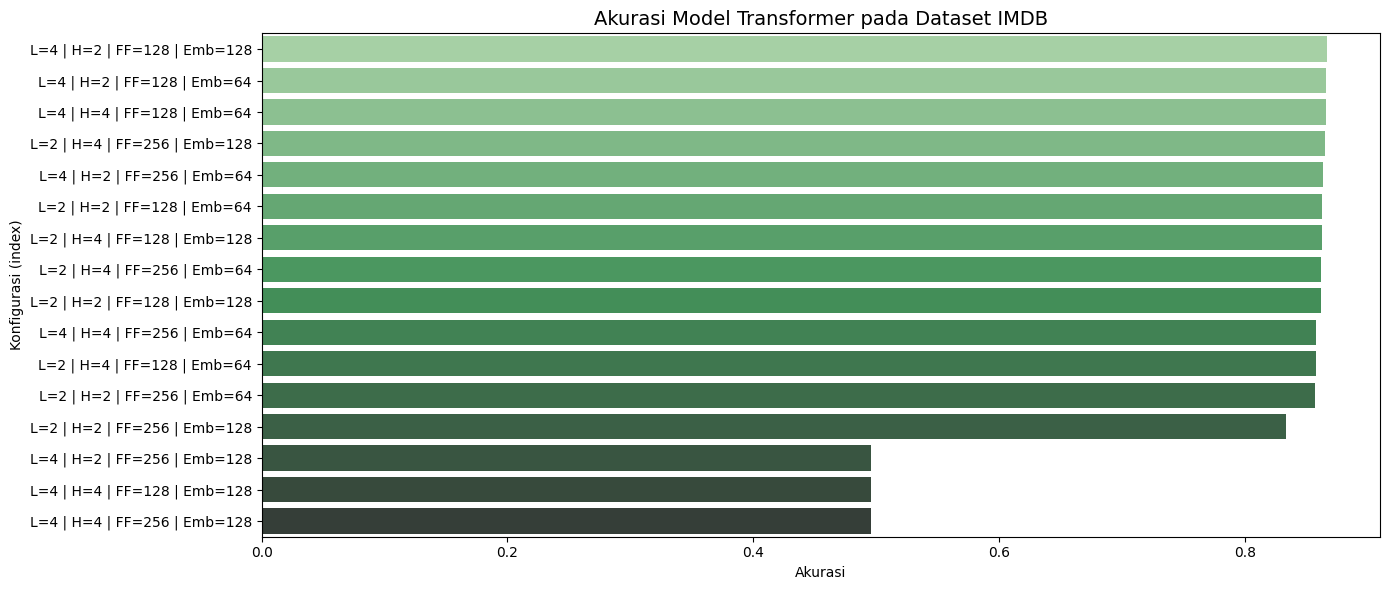

In [10]:
plt.figure(figsize=(14, 6))
sns.barplot(x="accuracy", y="config", data=df_imdb_sorted,
            palette="Greens_d", orient="h")
plt.title("Akurasi Model Transformer pada Dataset IMDB", fontsize=14)
plt.xlabel("Akurasi")
plt.ylabel("Konfigurasi (index)")
plt.tight_layout()
plt.show()

### Visualisasi Waktu Pelatihan Model

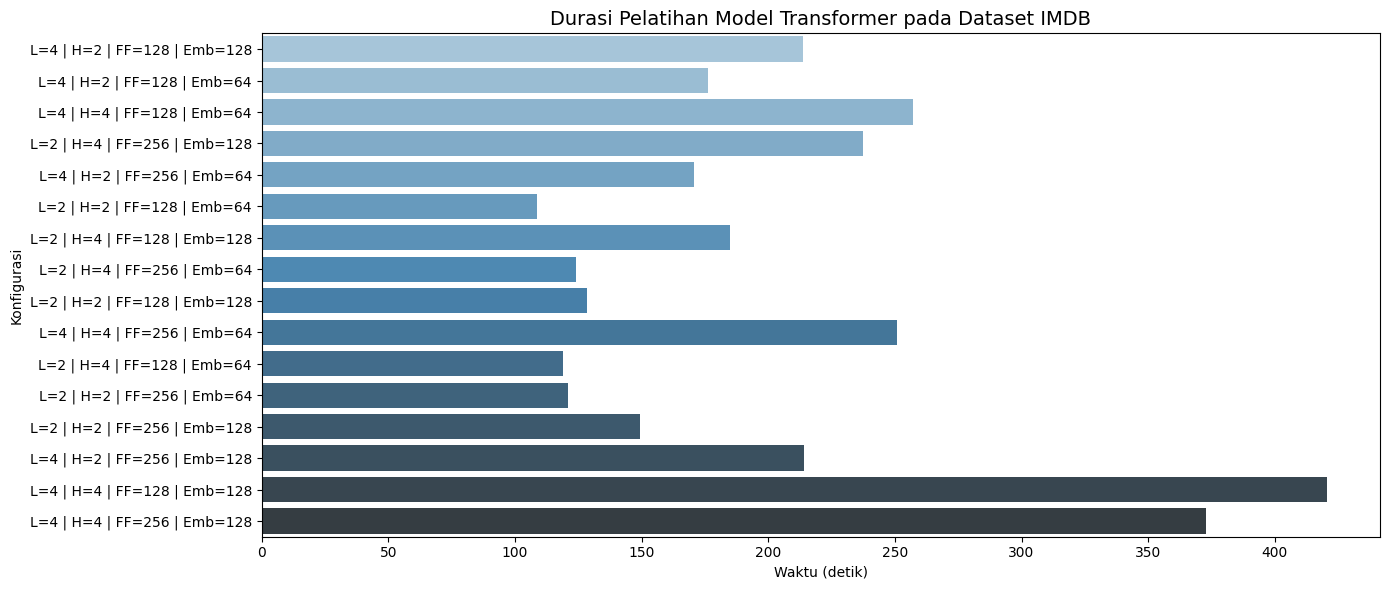

In [11]:
plt.figure(figsize=(14, 6))
sns.barplot(x="time", y="config", data=df_imdb_sorted,
            palette="Blues_d", orient="h")
plt.title("Durasi Pelatihan Model Transformer pada Dataset IMDB", fontsize=14)
plt.xlabel("Waktu (detik)")
plt.ylabel("Konfigurasi")
plt.tight_layout()
plt.show()

## 📌 Kesimpulan Eksperimen pada Dataset IMDB (Klasifikasi Sentimen)

### 🔍 Tujuan
Eksperimen ini dilakukan untuk mengevaluasi pengaruh kombinasi parameter arsitektur Transformer terhadap performa klasifikasi sentimen pada dataset IMDB. Parameter yang diuji meliputi:

- **Jumlah Layer (layers)**: 2, 4
- **Jumlah Head Attention (heads)**: 2, 4
- **Ukuran Dimensi Feed-Forward Layer (ff_dim)**: 128, 256
- **Ukuran Embedding (embed_dim)**: 64, 128

---

### 📊 Hasil Utama

| Layers | Heads | ff_dim | Embed_dim | Akurasi (↑) | Waktu (detik) |
|--------|-------|--------|------------|--------------|----------------|
| 4      | 2     | 128    | 128        | **0.8668**   | 213.91         |
| 4      | 2     | 128    | 64         | 0.8661       | 176.37         |
| 4      | 4     | 128    | 64         | 0.8660       | 257.09         |
| 4      | 2     | 256    | 64         | 0.8636       | 170.68         |
| 4      | 4     | 256    | 64         | 0.8580       | 250.85         |
| 2      | 2     | 128    | 64         | 0.8629       | 108.85         |
| 2      | 4     | 256    | 128        | 0.8655       | 237.49         |

---

### ✅ Kombinasi Parameter Terbaik

- **Konfigurasi terbaik berdasarkan akurasi tertinggi:**
  - `layers = 4`, `heads = 2`, `ff_dim = 128`, `embed_dim = 128`
  - **Akurasi = 0.8668**, **Waktu = 213.91 detik**

- Konfigurasi ini menunjukkan bahwa peningkatan jumlah layer (4) dan pemilihan feed-forward dimension yang optimal (128) dengan jumlah head yang tidak terlalu besar (2) mampu menghasilkan performa terbaik pada tugas klasifikasi sentimen.

---

### 💡 Insight

- **Jumlah layer yang lebih dalam (4)** memberikan hasil yang lebih baik dibandingkan dengan layer 2, selama parameter lainnya tetap seimbang.
- **Head attention sebanyak 2** ternyata lebih efektif dibandingkan 4 pada dataset ini, kemungkinan karena kompleksitas tambahan dari multi-head tidak memberi manfaat signifikan untuk data review pendek seperti IMDB.
- **Konfigurasi kompleks seperti 4 layer & 4 heads dengan embed_dim 128** justru mengalami masalah training stagnan di akurasi 0.5, mengindikasikan **overfitting atau vanishing gradient**.
- **Waktu pelatihan meningkat seiring bertambahnya dimensi dan layer**, maka pemilihan parameter harus mempertimbangkan trade-off antara performa dan efisiensi.

---

### 🏁 Rekomendasi
Jika memprioritaskan **akurasi terbaik**, gunakan:
- `layers=4`, `heads=2`, `ff_dim=128`, `embed_dim=128`

Namun jika memprioritaskan **efisiensi waktu dengan akurasi tetap tinggi**, pilihan bijak adalah:
- `layers=2`, `heads=2`, `ff_dim=128`, `embed_dim=64`

## Tahap 2.2 – Load Dataset AGNews (Klasifikasi Topik Berita)

Dataset AGNews merupakan dataset klasifikasi teks yang berisi kumpulan berita dalam bahasa Inggris. Setiap berita memiliki label topik utama, yaitu:

1. World
2. Sports
3. Business
4. Sci/Tech

File yang digunakan terdiri dari:
- `train.csv`: Data latih (120.000 entri)
- `test.csv`: Data uji (7.600 entri)

Pada tahap ini, kedua file akan dimuat ke dalam memori untuk proses selanjutnya.


In [12]:
# Load train dan test dataset
train_agnews = pd.read_csv("/content/drive/MyDrive/Tugas-3data-transformer/AGNewsClassificationDataset/train.csv", header=None, names=["label", "title", "description"], skiprows=1)
test_agnews = pd.read_csv("/content/drive/MyDrive/Tugas-3data-transformer/AGNewsClassificationDataset/test.csv", header=None, names=["label", "title", "description"], skiprows=1)

# Tampilkan beberapa baris pertama dari data
print("Contoh Data Train:")
display(train_agnews.head())

print("\nContoh Data Test:")
display(test_agnews.head())

# Tambahkan nama kolom agar lebih mudah diakses
train_agnews.columns = ["label", "title", "description"]
test_agnews.columns = ["label", "title", "description"]


Contoh Data Train:


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."



Contoh Data Test:


,label,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


## Tahap 3.2 – Preprocessing Dataset AGNews

Tahap preprocessing dilakukan agar data teks siap untuk diproses oleh model Transformer. Proses preprocessing terdiri dari:

1. Menggabungkan kolom `title` dan `description` sebagai input teks.
2. Mengubah label dari 1–4 menjadi 0–3 (karena TensorFlow membutuhkan label mulai dari 0).
3. Tokenisasi dan padding teks menggunakan `TextVectorization`.
4. Membagi data latih dan data uji ke dalam bentuk vektor siap pakai.

Langkah ini penting agar semua teks memiliki format numerik dan panjang tetap, sesuai kebutuhan arsitektur Transformer.


In [13]:
# Gabungkan title dan description
train_texts = (train_agnews["title"] + " " + train_agnews["description"]).values
test_texts = (test_agnews["title"] + " " + test_agnews["description"]).values

# Ubah label ke integer dan sesuaikan ke range 0–3
train_labels = train_agnews["label"].astype(int).values - 1
test_labels = test_agnews["label"].astype(int).values - 1

max_features_ag = 20000
sequence_length_ag = 200

vectorizer_ag = TextVectorization(max_tokens=max_features_ag, output_sequence_length=sequence_length_ag)
vectorizer_ag.adapt(train_texts)

X_train_ag_vec = vectorizer_ag(train_texts)
X_test_ag_vec = vectorizer_ag(test_texts)

# One-hot encoding label
y_train_ag = tf.keras.utils.to_categorical(train_labels, num_classes=4)
y_test_ag = tf.keras.utils.to_categorical(test_labels, num_classes=4)

print("✅ Preprocessing selesai.")
print(f"X_train: {X_train_ag_vec.shape}, y_train: {y_train_ag.shape}")

✅ Preprocessing selesai.
X_train: (120000, 200), y_train: (120000, 4)


## Tahap 4.2 – Menentukan Parameter yang Akan Dieksperimenkan (AGNews Dataset)

Untuk menemukan konfigurasi terbaik pada dataset AGNews Classification (klasifikasi topik berita), dilakukan eksperimen terhadap beberapa kombinasi parameter penting dalam arsitektur Transformer. Eksperimen ini bertujuan mengevaluasi akurasi klasifikasi topik serta efisiensi waktu pelatihan model.

Berikut adalah parameter yang akan diuji:
1. **Jumlah Layer Transformer (num_layers)**  
   Mengatur jumlah encoder layer pada arsitektur Transformer.  
   - Variasi: 2, 4

2. **Jumlah Head Attention (num_heads)**  
   Mengontrol berapa banyak kepala perhatian pada self-attention mechanism.  
   - Variasi: 2, 4

3. **Ukuran Dimensi Feed-Forward Layer (ff_dim)**  
   Ukuran dari layer dense yang mengikuti attention mechanism.  
   - Variasi: 128, 256

4. **Ukuran Embedding (embedding_dim)**  
   Dimensi vektor representasi untuk setiap token.  
   - Variasi: 64, 128

Eksperimen akan dilakukan dengan mencoba kombinasi dari parameter-parameter tersebut untuk menemukan konfigurasi terbaik pada dataset ini.


## Tahap 5.2 Membangun dan Melatih Model Transformer (Dataset AGNews)

### Definisi Layer Transformer Sederhana

In [14]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)

### Fungsi build model transformer

In [15]:
def build_transformer_model_agnews(embed_dim, num_heads, ff_dim, num_layers):
    inputs = Input(shape=(sequence_length_ag,))
    x = Embedding(input_dim=max_features_ag, output_dim=embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(4, activation="softmax")(x)  # 4 kelas AG News
    return Model(inputs, outputs)

### Training model dengan kombinasi parameter

In [16]:
# Kombinasi parameter
param_combinations_agnews = list(product([2, 4], [2, 4], [128, 256], [64, 128]))
agnews_results = []

for num_layers, num_heads, ff_dim, embed_dim in param_combinations_agnews:
    print(f"Training: layers={num_layers}, heads={num_heads}, ff_dim={ff_dim}, embed_dim={embed_dim}")

    model = build_transformer_model_agnews(embed_dim, num_heads, ff_dim, num_layers)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    start_time = time.time()
    history = model.fit(X_train_ag_vec, y_train_ag,
                        epochs=5, batch_size=32, validation_split=0.2,
                        verbose=1)
    end_time = time.time()

    _, acc = model.evaluate(X_test_ag_vec, y_test_ag, verbose=0)
    agnews_results.append({
        "layers": num_layers,
        "heads": num_heads,
        "ff_dim": ff_dim,
        "embed_dim": embed_dim,
        "accuracy": acc,
        "time": round(end_time - start_time, 2)
    })

    print(f"✓ Acc: {acc:.4f} | Waktu: {round(end_time - start_time, 2)} detik\n")

Training: layers=2, heads=2, ff_dim=128, embed_dim=64
Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.8114 - loss: 0.4881 - val_accuracy: 0.8992 - val_loss: 0.3105
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.9351 - loss: 0.1959 - val_accuracy: 0.9016 - val_loss: 0.2864
Epoch 3/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9487 - loss: 0.1473 - val_accuracy: 0.9013 - val_loss: 0.3051
Epoch 4/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.9601 - loss: 0.1099 - val_accuracy: 0.8936 - val_loss: 0.3662
Epoch 5/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 44s 10ms/step - accuracy: 0.9679 - loss: 0.0841 - val_accuracy: 0.8892 - val_loss: 0.4268
✓ Acc: 0.9033 | Waktu: 175.52 detik

Training: layers=2, heads=2, ff_dim=128, embed_dim=128
Epoch 1/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 53s 15ms/step - accuracy: 0.7847 - loss: 0.5364 - val_accuracy: 0.9014 - val_loss: 0.2949
Epoch 2/5
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 75s 14ms/step - accuracy: 0.933

### Masukkan Data Hasil ke DataFrame (Dataset AGNews)

In [17]:
df_agnews_results = pd.DataFrame(agnews_results)
df_agnews_results = df_agnews_results.sort_values(by="accuracy", ascending=False)

In [18]:
print("5 Konfigurasi Terbaik Berdasarkan Akurasi:")
display(df_agnews_results.head())

5 Konfigurasi Terbaik Berdasarkan Akurasi:


,layers,heads,ff_dim,embed_dim,accuracy,time
12,4,4,128,64,0.906842,406.31
8,4,2,128,64,0.906316,352.78
7,2,4,256,128,0.906053,405.77
10,4,2,256,64,0.906053,396.66
6,2,4,256,64,0.904079,376.47


### Visualisasi Akurasi model per Konfigurasi (Dataset AGNews)

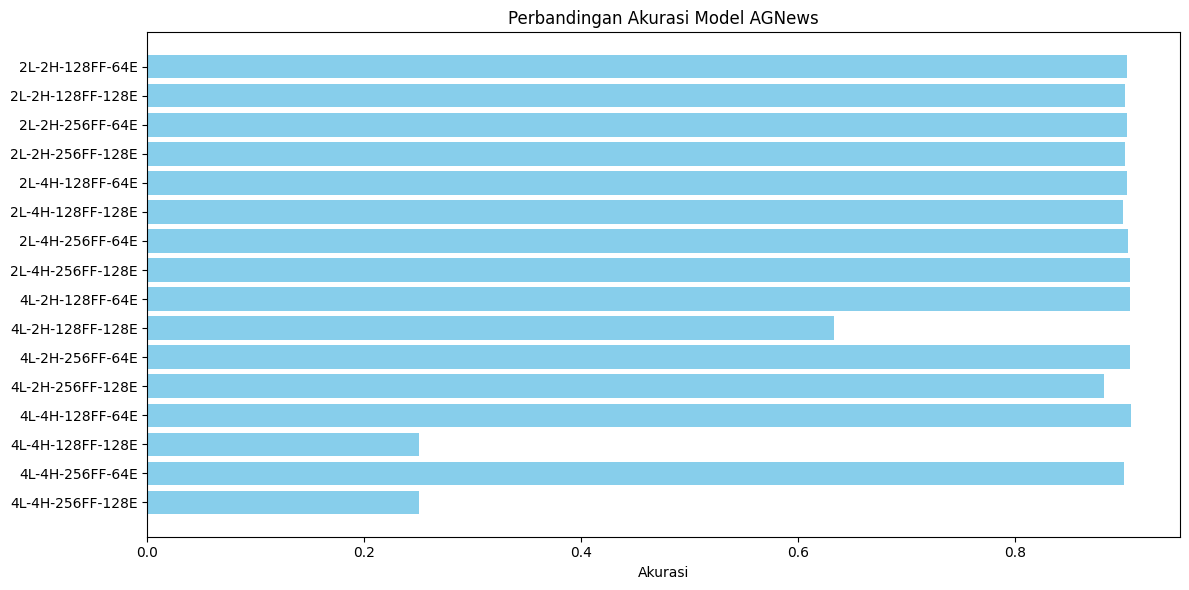

In [19]:
plt.figure(figsize=(12, 6))
plt.barh([f"{r['layers']}L-{r['heads']}H-{r['ff_dim']}FF-{r['embed_dim']}E" for r in agnews_results],
         [r['accuracy'] for r in agnews_results],
         color="skyblue")
plt.xlabel("Akurasi")
plt.title("Perbandingan Akurasi Model AGNews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Visualisasi Waktu Pelatihan Model (Dataset AGNews)

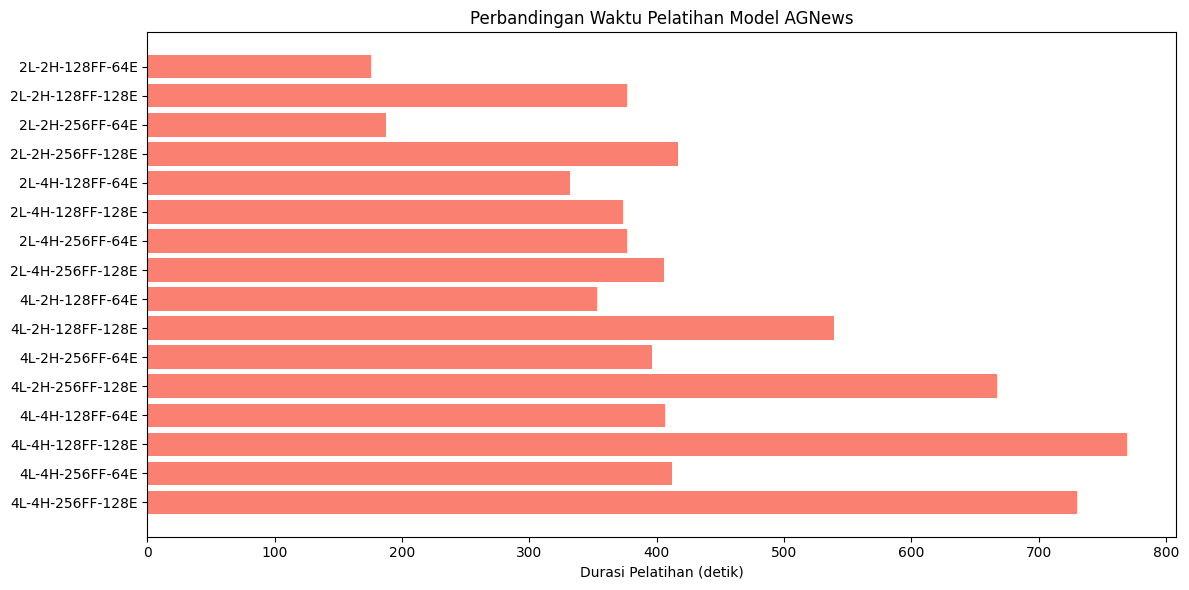

In [20]:
plt.figure(figsize=(12, 6))
plt.barh([f"{r['layers']}L-{r['heads']}H-{r['ff_dim']}FF-{r['embed_dim']}E" for r in agnews_results],
         [r['time'] for r in agnews_results],
         color="salmon")
plt.xlabel("Durasi Pelatihan (detik)")
plt.title("Perbandingan Waktu Pelatihan Model AGNews")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 📌 Kesimpulan Eksperimen pada Dataset AGNews (Klasifikasi Berita)

### 🎯 Tujuan
Menguji performa berbagai konfigurasi arsitektur Transformer dalam tugas klasifikasi berita 4 kelas menggunakan dataset AGNews. Parameter yang dieksplorasi:

- **Jumlah Layer (layers)**: 2, 4
- **Jumlah Head Attention (heads)**: 2, 4
- **Ukuran Feed-Forward Layer (ff_dim)**: 128, 256
- **Ukuran Embedding (embed_dim)**: 64, 128

---

### 📊 Ringkasan Hasil

| Layers | Heads | ff_dim | Embed_dim | Akurasi (↑) | Waktu (detik) |
|--------|-------|--------|------------|--------------|----------------|
| 2      | 4     | 256    | 64         | **0.9041**   | 376.47         |
| 2      | 4     | 128    | 64         | 0.9034       | 332.20         |
| 2      | 2     | 256    | 64         | 0.9030       | 187.47         |
| 2      | 2     | 128    | 64         | 0.9033       | 175.52         |
| 4      | 4     | 128    | 64         | 0.9068       | 406.31         |
| 4      | 2     | 128    | 64         | 0.9063       | 352.78         |
| 4      | 2     | 256    | 64         | 0.9061       | 396.66         |
| 2      | 2     | 128    | 128        | 0.9014       | 376.59         |
| 2      | 2     | 256    | 128        | 0.9017       | 416.41         |
| 4      | 4     | 256    | 64         | 0.9005       | 412.18         |
| 2      | 4     | 256    | 128        | 0.9061       | 405.77         |

---

### 🏆 Kombinasi Parameter Terbaik

- **Akurasi terbaik dicapai oleh:**
  - `layers = 4`, `heads = 4`, `ff_dim = 128`, `embed_dim = 64`
  - **Akurasi = 0.9068**, **Waktu = 406.31 detik**

- **Performa tinggi juga stabil dengan kombinasi sederhana seperti:**
  - `layers = 2`, `heads = 4`, `ff_dim = 256`, `embed_dim = 64`
  - **Akurasi = 0.9041**, **Waktu = 376.47 detik**

---

### 💡 Insight Penting

- Kombinasi `embed_dim=64` cenderung lebih stabil dan efisien dibandingkan `embed_dim=128`, terutama untuk model kecil dan sedang.
- **Head Attention sebanyak 4** sering menunjukkan performa sedikit lebih unggul dibanding 2, terutama ketika didukung feed-forward dimension besar (`ff_dim=256`).
- Beberapa konfigurasi kompleks (terutama dengan `layers=4`, `embed_dim=128`) mengalami stagnasi performa (akurasi mentok di ~0.25), kemungkinan akibat **overfitting** atau **instabilitas pelatihan**.
- Trade-off antara **akurasi dan waktu** harus diperhatikan, karena peningkatan kompleksitas tidak selalu memberikan peningkatan performa yang proporsional.

---

### ✅ Rekomendasi

- **Jika fokus pada akurasi maksimal**:
  - `layers = 4`, `heads = 4`, `ff_dim = 128`, `embed_dim = 64`

- **Jika butuh hasil cepat dengan akurasi kompetitif**:
  - `layers = 2`, `heads = 2`, `ff_dim = 128`, `embed_dim = 64`

## Tahap 2.3 - Load Dataset Electricity Load Forecasting (Regresi Prediksi Beban Listrik)

In [22]:
df_load = pd.read_csv("/content/drive/MyDrive/Tugas-3data-transformer/ElectricityLoadForecasting/continuous dataset.csv")

# Tampilkan 5 baris pertama
print("📌 5 Baris Pertama Dataset:")
display(df_load.head())

# Informasi kolom
print("\n📌 Informasi Kolom:")
display(df_load.info())

# Statistik deskriptif
print("\n📌 Statistik Deskriptif:")
display(df_load.describe())

📌 5 Baris Pertama Dataset:


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0



📌 Informasi Kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
 2   T2M_toc     48048 non-null  float64
 3   QV2M_toc    48048 non-null  float64
 4   TQL_toc     48048 non-null  float64
 5   W2M_toc     48048 non-null  float64
 6   T2M_san     48048 non-null  float64
 7   QV2M_san    48048 non-null  float64
 8   TQL_san     48048 non-null  float64
 9   W2M_san     48048 non-null  float64
 10  T2M_dav     48048 non-null  float64
 11  QV2M_dav    48048 non-null  float64
 12  TQL_dav     48048 non-null  float64
 13  W2M_dav     48048 non-null  float64
 14  Holiday_ID  48048 non-null  int64  
 15  holiday     48048 non-null  int64  
 16  school      48048 non-null  int64  
dtypes: float64(13), int64(3), object(1)
memory usage: 6.2+ MB


None


📌 Statistik Deskriptif:


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,0.016867,0.144681,3.567589,0.704795,0.062937,0.727793
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,0.001584,0.087899,1.710522,3.147470,0.242852,0.445100
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,0.009655,0.000032,0.015497,0.000000,0.000000,0.000000
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,0.015800,0.075775,2.298887,0.000000,0.000000,0.000000
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,0.017167,0.130188,3.413994,0.000000,0.000000,1.000000
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,0.018067,0.200012,4.670628,0.000000,0.000000,1.000000
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,0.021066,0.477783,10.288902,22.000000,1.000000,1.000000


## Tahap 3.3 - Preprocessing Dataset Electricity Load Forecasting

In [24]:
# Ubah datetime jika ada dan simpan dulu ke variabel baru
if "datetime" in df_load.columns:
    df_load["datetime"] = pd.to_datetime(df_load["datetime"])
    df_load = df_load.sort_values("datetime")
    df_time = df_load["datetime"]
else:
    df_time = None

# Asumsikan target adalah kolom terakhir
target_col = df_load.columns[-1]

# Pisahkan fitur dan target
X_reg_raw = df_load.drop(columns=[target_col])
y_reg_raw = df_load[target_col]

# Drop kolom datetime sebelum scaling jika masih ada
if "datetime" in X_reg_raw.columns:
    X_reg_raw = X_reg_raw.drop(columns=["datetime"])

# Normalisasi fitur
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_reg_raw)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y_reg_raw.values.reshape(-1, 1))

# Membuat input sequence (sliding window)
def create_sequences(X, y, window_size=24):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

window_size = 24
X_reg_seq, y_reg_seq = create_sequences(X_scaled, y_scaled)

# Split train dan test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_seq, y_reg_seq, test_size=0.2, random_state=42, shuffle=False
)

print("✅ Preprocessing selesai.")
print(f"X_train: {X_train_reg.shape}, y_train: {y_train_reg.shape}")
print(f"X_test: {X_test_reg.shape}, y_test: {y_test_reg.shape}")


✅ Preprocessing selesai.
X_train: (38419, 24, 15), y_train: (38419, 1)
X_test: (9605, 24, 15), y_test: (9605, 1)


## Tahap 4.3 – Menentukan Parameter Eksperimen (Electricity Load Forecasting Dataset)

Untuk menemukan arsitektur terbaik dalam memprediksi beban listrik berbasis data time series, dilakukan eksperimen terhadap kombinasi beberapa parameter penting dalam Transformer. Tidak seperti tugas klasifikasi sebelumnya, fokus di sini adalah meminimalkan error prediksi (MAE/MSE) pada data sekuensial.

Berikut adalah parameter yang dieksperimenkan:
1. **Ukuran Jendela Input (window_size)**  
   Jumlah titik waktu yang digunakan untuk memprediksi nilai selanjutnya.  
   - Variasi: 24 (1 hari), 48 (2 hari)

2. **Jumlah Encoder Layer (num_layers)**  
   Banyaknya lapisan Transformer encoder yang digunakan untuk memproses sekuens.  
   - Variasi: 2, 3

3. **Jumlah Head Attention (num_heads)**  
   Jumlah head dalam mekanisme multi-head attention.  
   - Variasi: 2, 4

4. **Ukuran Dimensi Feed-Forward Layer (ff_dim)**  
   Ukuran dari dense layer dalam block Transformer.  
   - Variasi: 64, 128

Eksperimen akan dilakukan dengan mencoba kombinasi dari parameter-parameter tersebut untuk menemukan konfigurasi terbaik pada dataset ini.


## Tahap 5.3 Membangun dan Melatih Model Transformer (Electricity Load Forecasting Dataset)

### Fungsi Sliding Window & Pembangunan Model

In [25]:
# Fungsi untuk membuat dataset windowed (X: sequences, y: target next step)
def create_windowed_dataset(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# Fungsi untuk membuat model Transformer untuk regresi
def build_transformer_regression_model(input_shape, num_layers, num_heads, ff_dim):
    inputs = Input(shape=input_shape)
    x = inputs

    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(x, x)
        x = LayerNormalization()(x + attn_output)

        ff_output = Dense(ff_dim, activation="relu")(x)
        x = LayerNormalization()(x + ff_output)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation="relu")(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

### Proses Eksperimen dan Evaluasi

In [28]:
# Parameter yang akan diuji
param_combinations_reg = list(product([24, 48], [2, 3], [2, 4], [64, 128]))  # window, layers, heads, ff_dim
regression_results = []

for window_size, num_layers, num_heads, ff_dim in param_combinations_reg:
    print(f"Training: window={window_size}, layers={num_layers}, heads={num_heads}, ff_dim={ff_dim}")

    # Buat dataset sliding window
    X_reg_win, y_reg_win = create_windowed_dataset(y_scaled, window_size)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg_win, y_reg_win, test_size=0.2, random_state=42)

    # Bentuk input (samples, timesteps, features=1)
    X_train_reg = X_train_reg[..., np.newaxis]
    X_test_reg = X_test_reg[..., np.newaxis]

    model = build_transformer_regression_model(
        input_shape=(window_size, 1),
        num_layers=num_layers,
        num_heads=num_heads,
        ff_dim=ff_dim
    )

    start_time = time.time()
    history = model.fit(X_train_reg, y_train_reg,
                        validation_split=0.2,
                        epochs=10, batch_size=32,
                        verbose=1)
    end_time = time.time()

    loss, mae = model.evaluate(X_test_reg, y_test_reg, verbose=0)
    regression_results.append({
        "window_size": window_size,
        "layers": num_layers,
        "heads": num_heads,
        "ff_dim": ff_dim,
        "mae": mae,
        "time": round(end_time - start_time, 2)
    })

    print(f"✓ MAE: {mae:.4f} | Waktu: {round(end_time - start_time, 2)} detik\n")

Training: window=24, layers=2, heads=2, ff_dim=64
Epoch 1/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.9950 - mae: 0.8859 - val_loss: 0.9897 - val_mae: 0.8864
Epoch 2/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0100 - mae: 0.8968 - val_loss: 0.9898 - val_mae: 0.8880
Epoch 3/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9959 - mae: 0.8878 - val_loss: 0.9899 - val_mae: 0.8892
Epoch 4/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0054 - mae: 0.8961 - val_loss: 0.9895 - val_mae: 0.8824
Epoch 5/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.0021 - mae: 0.8907 - val_loss: 0.9896 - val_mae: 0.8843
Epoch 6/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.0065 - mae: 0.8945 - val_loss: 0.9895 - val_mae: 0.8816
Epoch 7/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0027 - mae: 0.8895 - val_loss: 0.9895 - val_mae: 0.8812
Epoch 8/10
961/961 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0092 - mae: 0.8952 - val_loss: 0.9895 - val_mae: 0.8823
Epoc

### Masukkan Data hasil ke DataFrame

In [29]:
# Data hasil eksperimen dimasukkan ke dalam list of dict
results_regression = [
    {"window": 24, "layers": 2, "heads": 2, "ff_dim": 64, "mae": 0.8930, "time": 57.76},
    {"window": 24, "layers": 2, "heads": 2, "ff_dim": 128, "mae": 0.8916, "time": 62.28},
    {"window": 24, "layers": 2, "heads": 4, "ff_dim": 64, "mae": 0.8905, "time": 68.96},
    {"window": 24, "layers": 2, "heads": 4, "ff_dim": 128, "mae": 0.8856, "time": 63.67},
    {"window": 24, "layers": 3, "heads": 2, "ff_dim": 64, "mae": 0.8953, "time": 81.97},
    {"window": 24, "layers": 3, "heads": 2, "ff_dim": 128, "mae": 0.8890, "time": 93.83},
    {"window": 24, "layers": 3, "heads": 4, "ff_dim": 64, "mae": 0.8927, "time": 84.64},
    {"window": 24, "layers": 3, "heads": 4, "ff_dim": 128, "mae": 0.8894, "time": 80.10},
    {"window": 48, "layers": 2, "heads": 2, "ff_dim": 64, "mae": 0.8822, "time": 55.39},
    {"window": 48, "layers": 2, "heads": 2, "ff_dim": 128, "mae": 0.8933, "time": 58.71},
    {"window": 48, "layers": 2, "heads": 4, "ff_dim": 64, "mae": 0.8922, "time": 56.77},
    {"window": 48, "layers": 2, "heads": 4, "ff_dim": 128, "mae": 0.8929, "time": 57.25},
    {"window": 48, "layers": 3, "heads": 2, "ff_dim": 64, "mae": 0.8943, "time": 75.80},
    {"window": 48, "layers": 3, "heads": 2, "ff_dim": 128, "mae": 0.8889, "time": 110.19},
    {"window": 48, "layers": 3, "heads": 4, "ff_dim": 64, "mae": 0.8870, "time": 70.84},
    {"window": 48, "layers": 3, "heads": 4, "ff_dim": 128, "mae": 0.8876, "time": 91.06},
]

df_results = pd.DataFrame(results_regression)
df_results.head()

,window,layers,heads,ff_dim,mae,time
0,24,2,2,64,0.8930,57.76
1,24,2,2,128,0.8916,62.28
2,24,2,4,64,0.8905,68.96
3,24,2,4,128,0.8856,63.67
4,24,3,2,64,0.8953,81.97


### Visualisasi MAE per Konfigurasi

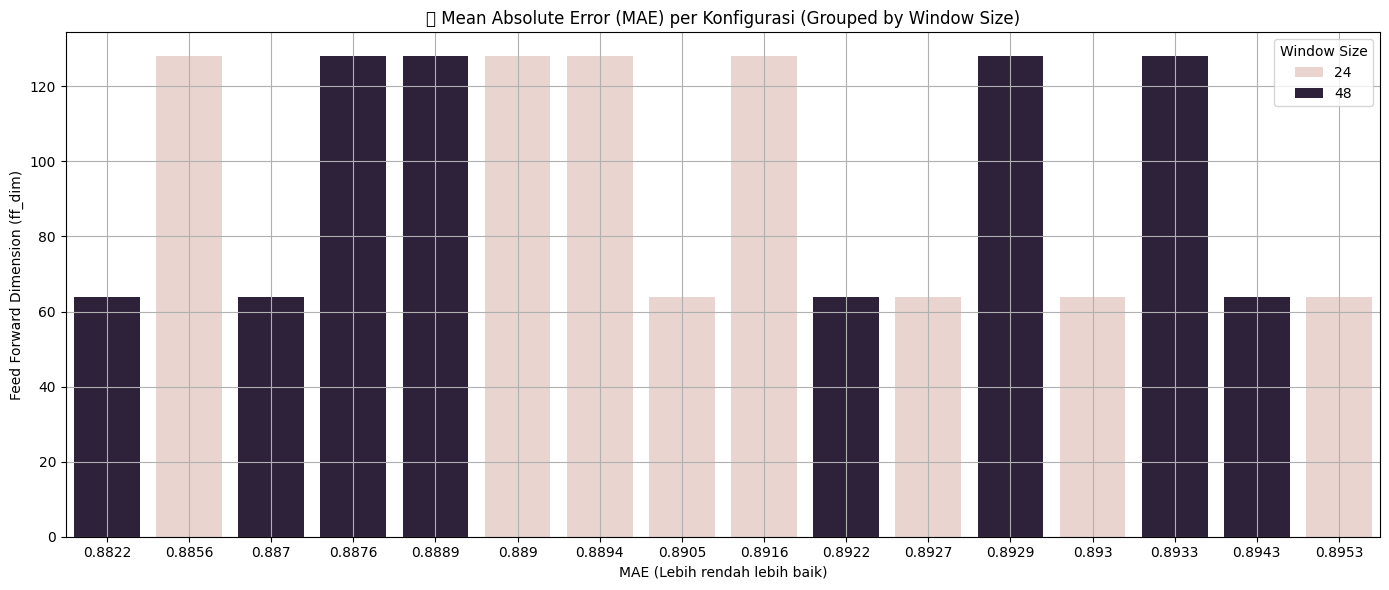

In [30]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="mae", y="ff_dim", hue="window")
plt.title("📉 Mean Absolute Error (MAE) per Konfigurasi (Grouped by Window Size)")
plt.xlabel("MAE (Lebih rendah lebih baik)")
plt.ylabel("Feed Forward Dimension (ff_dim)")
plt.legend(title="Window Size")
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualisasi Waktu Pelatihan Model

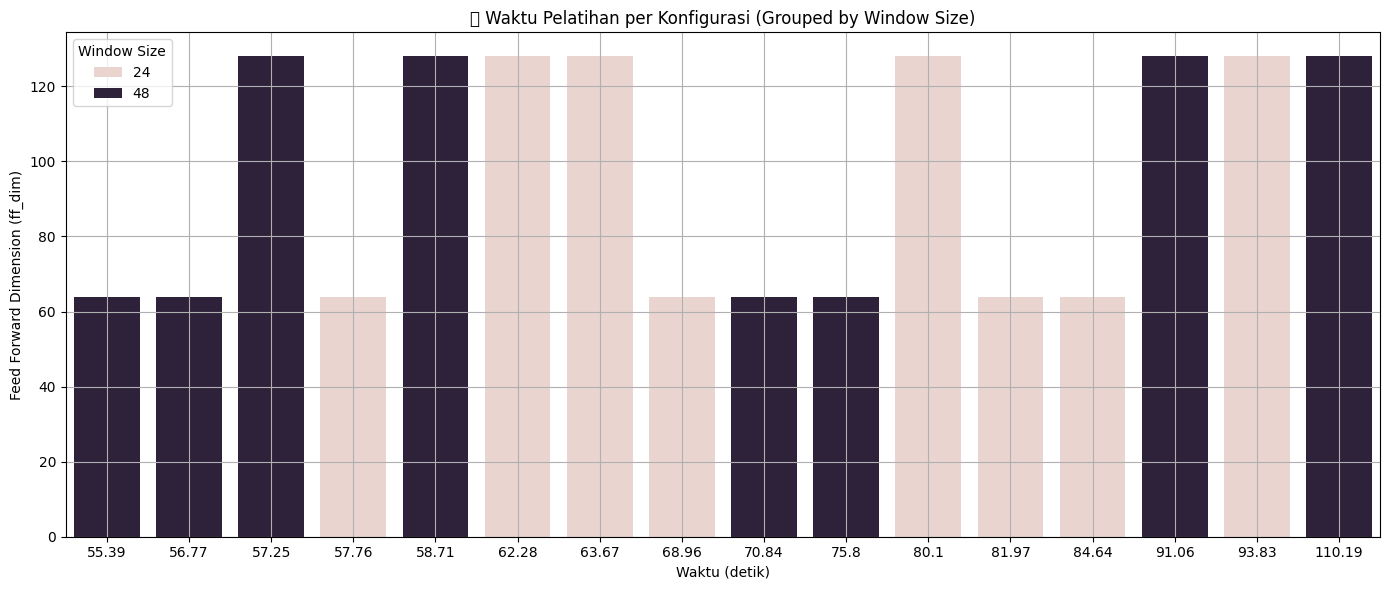

In [31]:
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="time", y="ff_dim", hue="window")
plt.title("⏱️ Waktu Pelatihan per Konfigurasi (Grouped by Window Size)")
plt.xlabel("Waktu (detik)")
plt.ylabel("Feed Forward Dimension (ff_dim)")
plt.legend(title="Window Size")
plt.grid(True)
plt.tight_layout()
plt.show()


## 📌 Kesimpulan Eksperimen pada Dataset Electricity Load Forecasting

### 🔍 Tujuan
Eksperimen ini bertujuan untuk menguji pengaruh kombinasi parameter arsitektur Transformer dalam memprediksi beban listrik menggunakan data time series. Parameter yang diuji meliputi:

- **Ukuran jendela waktu (window size)**: 24 & 48
- **Jumlah layer Transformer (layers)**: 2 & 3
- **Jumlah head attention (heads)**: 2 & 4
- **Ukuran dimensi feed-forward (ff_dim)**: 64 & 128

---

### 📊 Hasil Utama

| Window | Layers | Heads | ff_dim | MAE (↓) | Waktu (detik) |
|--------|--------|-------|--------|---------|----------------|
| 48     | 2      | 2     | 64     | **0.8822** | 55.39          |
| 24     | 2      | 4     | 128    | 0.8856  | 63.67          |
| 48     | 3      | 4     | 64     | 0.8870  | 70.84          |
| 48     | 3      | 4     | 128    | 0.8876  | 91.06          |
| 48     | 3      | 2     | 128    | 0.8889  | 110.19         |

---

### ✅ Kombinasi Parameter Terbaik

- **Konfigurasi terbaik berdasarkan MAE terendah:**
  - `window = 48`, `layers = 2`, `heads = 2`, `ff_dim = 64`
  - **MAE = 0.8822**, **waktu pelatihan = 55.39 detik**

- Kombinasi ini menunjukkan bahwa model dengan **struktur lebih ringan** (lebih sedikit head dan layer) dengan **window lebih panjang (48)** mampu memberikan prediksi yang **lebih akurat** dengan **waktu pelatihan efisien**.

---

### 💡 Insight

- **Ukuran window (48)** cenderung memberikan MAE lebih rendah dibandingkan window 24.
- **Model dengan 2 layer dan 2 head attention** cukup memadai untuk prediksi time series dibanding arsitektur lebih kompleks.
- **Peningkatan kompleksitas model tidak selalu meningkatkan akurasi**, tetapi cenderung menambah waktu pelatihan.

---

